In [3]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns

import process as pp
import db_connect

%load_ext autoreload
%autoreload 2

connection = db_connect.start_conn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
test = annual_byBoro['count'].pct_change(n=1)
test

What type of "interest rates" most affect property sales? Specifically speaking about normal family homes and commercial property (both small and large office types). I am analyzing the NYC rolling sales data and see that 

count
f64
null
-0.519856
2.160728
0.162315
-0.67657
…
0.967496
-0.651949
2.654561


In [53]:
annual_sales.sort("year").with_columns(
    pl.col("count").pct_change().alias("annual_rate_of_change")
)

year,count,annual_rate_of_change
"decimal[*,0]",i64,f64
2003,118428,null
2004,126591,0.068928
2005,123643,-0.023288
2006,115472,-0.066085
2007,107009,-0.07329
…,…,…
2019,83920,0.001647
2020,68684,-0.181554
2021,99090,0.442694


# Data Visualization

C:\Users\yangt\AppData\Local\Temp\ipykernel_2292\2037358156.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(labels=annual_sales['year'], rotation=45)
C:\Users\yangt\AppData\Local\Temp\ipykernel_2292\2037358156.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


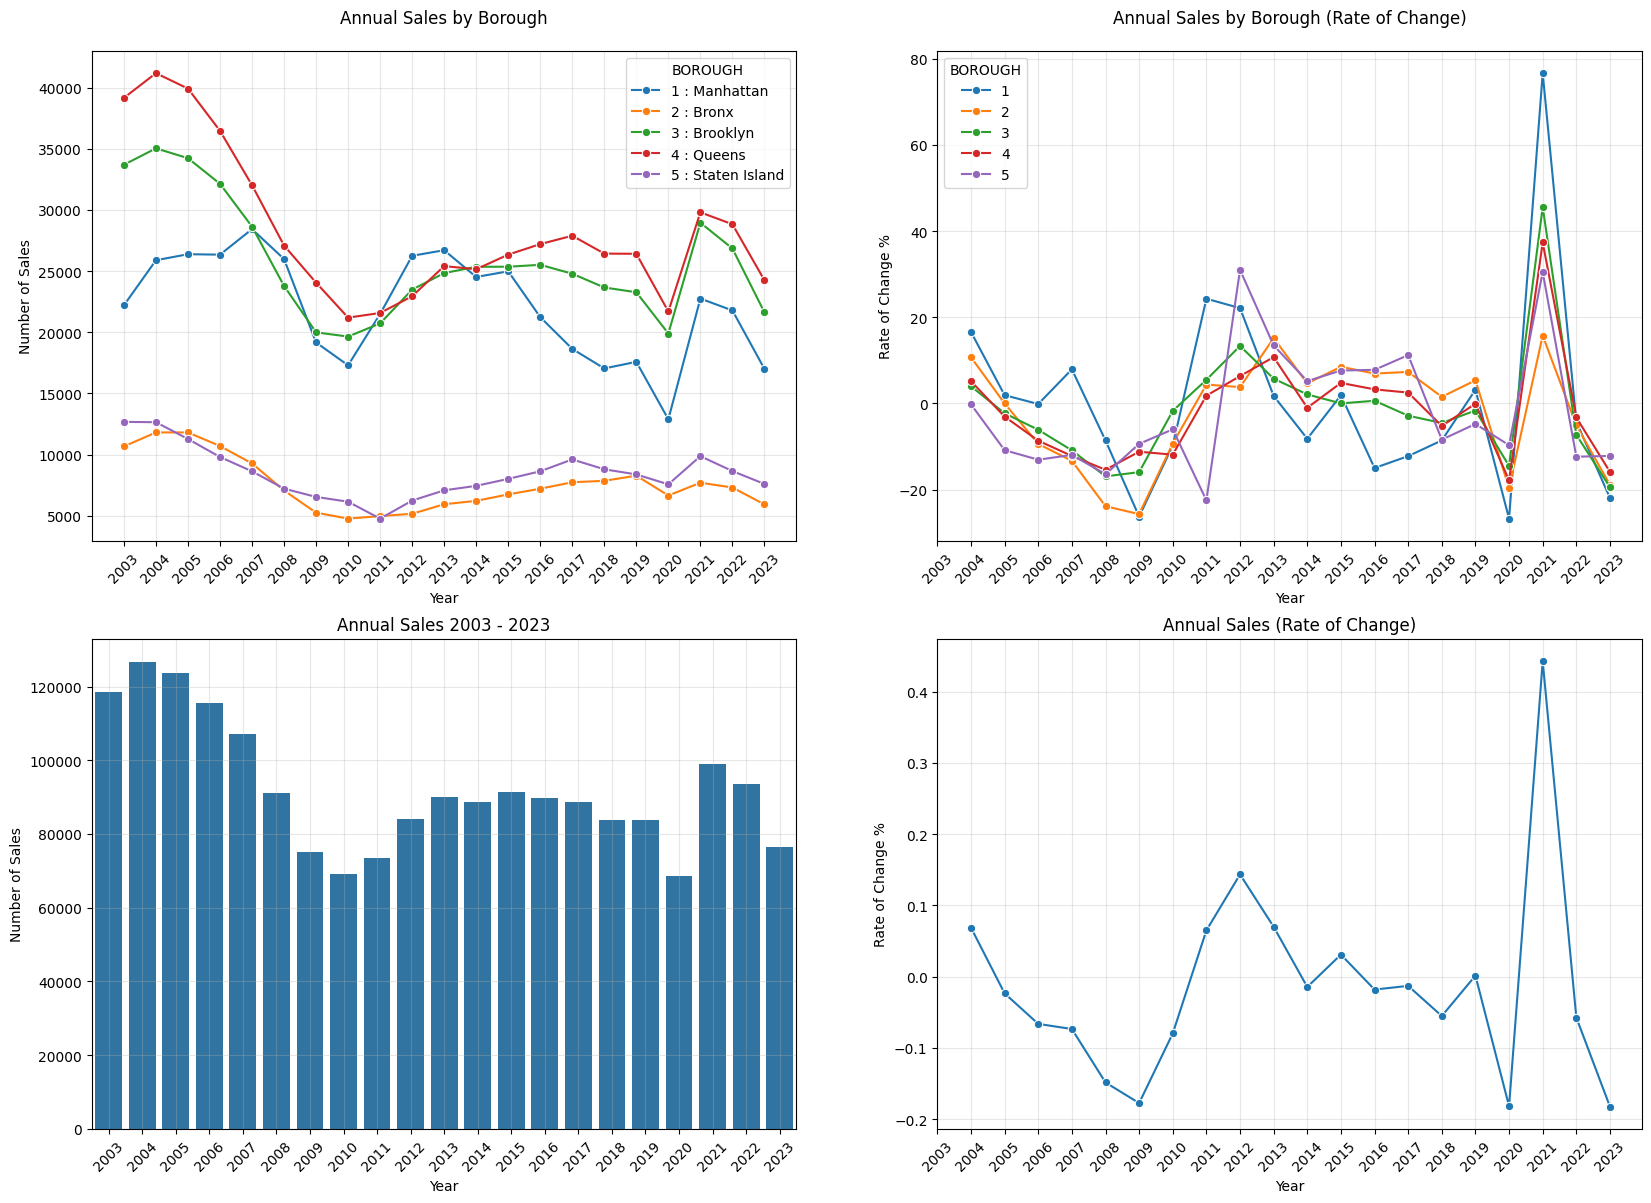

In [59]:
query1 = """
SELECT EXTRACT(YEAR FROM "SALE DATE") as year, 
       "BOROUGH",
       COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(YEAR FROM "SALE DATE"), "BOROUGH"
ORDER BY year, "BOROUGH"
"""
annual_byBoro = pl.read_database(query = query1, connection = connection)
annual_byBoro_roc = annual_byBoro.sort(["BOROUGH", "year"]).with_columns(
    (pl.col("count").pct_change().over("BOROUGH")*100).alias("roc")
)

fig, axs = plt.subplots(2,2)

sns.lineplot(
    data=annual_byBoro.to_pandas(),
    x='year',
    y='count',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    marker='o',
    ax=axs[0,0]
)

borough_names = ["1 : Manhattan", "2 : Bronx", "3 : Brooklyn", "4 : Queens", "5 : Staten Island"]

axs[0,0].set_title('Annual Sales by Borough', pad=20)
axs[0,0].set_xlabel('Year')
axs[0,0].set_xticks(annual_byBoro['year'].unique().sort())
axs[0,0].set_xticklabels(annual_byBoro['year'].unique().sort(), rotation=45)
axs[0,0].set_ylabel('Number of Sales')
axs[0,0].grid(True, alpha=0.3)
sns.move_legend(
    axs[0,0], 
    "upper right",
    # bbox_to_anchor=(1.05,1),
    labels=borough_names
)

sns.lineplot(
    data=annual_byBoro_roc.to_pandas(),
    x='year',
    y='roc',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    marker='o',
    ax=axs[0,1]
)

axs[0,1].set_title('Annual Sales by Borough (Rate of Change)', pad=20)
axs[0,1].set_xlabel('Year')
axs[0,1].set_xticks(annual_byBoro['year'].unique().sort())
axs[0,1].set_xticklabels(annual_byBoro['year'].unique().sort(), rotation=45)
axs[0,1].set_ylabel('Rate of Change %')
axs[0,1].grid(True, alpha=0.3)

annual_sales=annual_byBoro.group_by("year").agg(pl.col("count").sum().alias("count")).sort("year")
annual_sales_roc=annual_sales.sort("year").with_columns(
    pl.col("count").pct_change().alias("roc")
)

sns.barplot(
    data=annual_sales.to_pandas(),
    x='year',
    y='count',
    ax=axs[1,0]
)

axs[1,0].set_title('Annual Sales 2003 - 2023')
axs[1,0].set_xlabel('Year')
axs[1,0].set_xticklabels(labels=annual_sales['year'], rotation=45)
axs[1,0].set_ylabel('Number of Sales')
axs[1,0].grid(True, alpha=0.3)

sns.lineplot(
    data=annual_sales_roc.to_pandas(),
    x='year',
    y='roc',
    palette=["C0", "C1", "C2", "C3", "C4"],
    marker='o',
    ax=axs[1,1]
)

axs[1,1].set_title('Annual Sales (Rate of Change)')
axs[1,1].set_xlabel('Year')
axs[1,1].set_xticks(annual_sales_roc['year'].unique().sort())
axs[1,1].set_xticklabels(annual_sales_roc['year'].unique().sort(), rotation=45)
axs[1,1].set_ylabel('Rate of Change %')
axs[1,1].grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
# plt.tight_layout()
fig.set_figheight(14)
fig.set_figwidth(20)

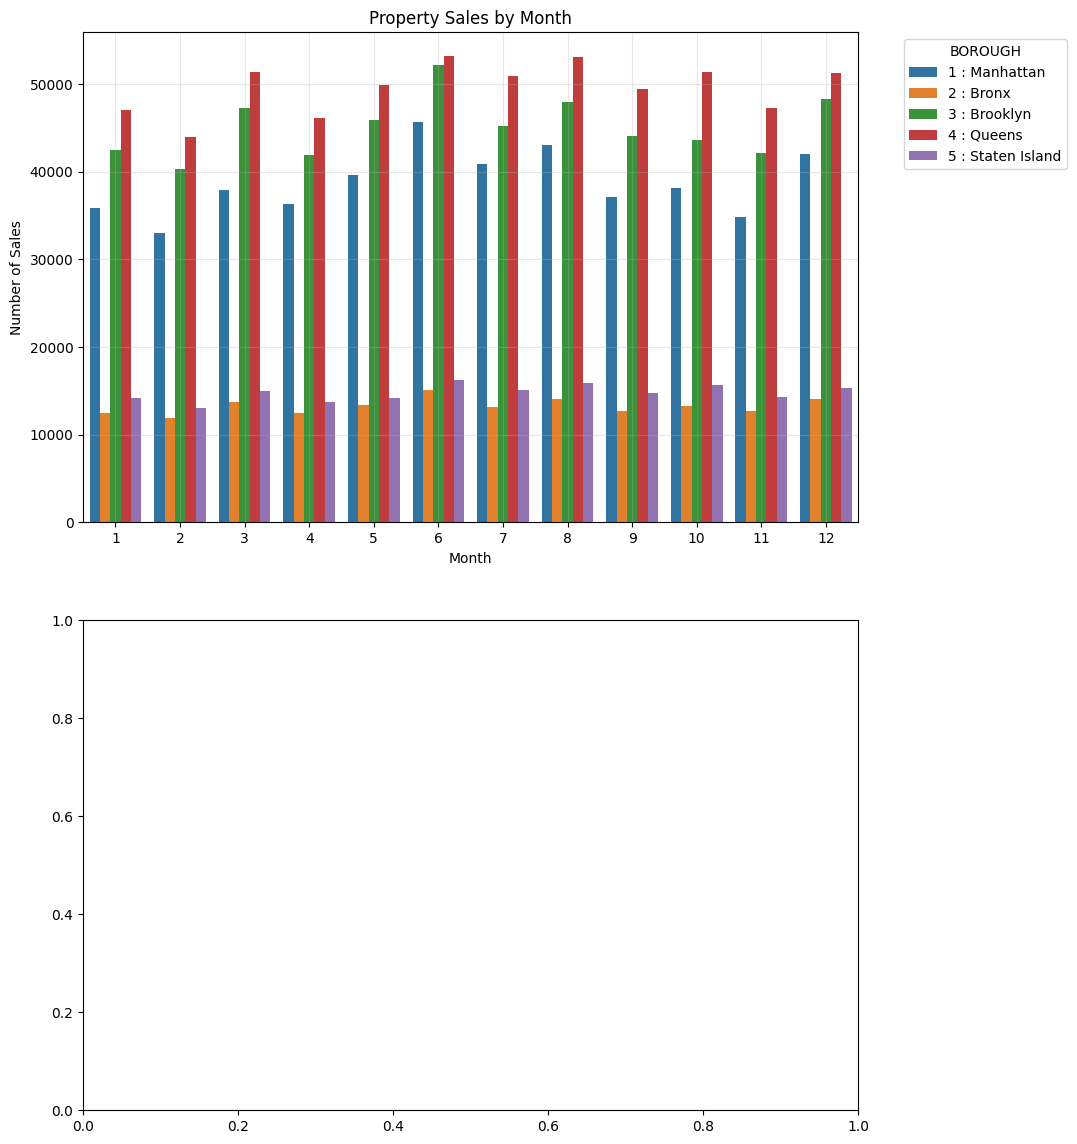

In [ ]:
fig, axs = plt.subplots(2,2)

query2 = """
SELECT EXTRACT(MONTH FROM "SALE DATE") as month,
    "BOROUGH",
    COUNT(*) as count
FROM rolling_sales
GROUP BY EXTRACT(MONTH FROM "SALE DATE"), "BOROUGH"
ORDER BY month, "BOROUGH"
"""

monthly_byBoro = pl.read_database(query = query2, connection = connection)

sns.barplot(
    data=monthly_byBoro.to_pandas(),
    x='month',
    y='count',
    hue='BOROUGH',
    palette=["C0", "C1", "C2", "C3", "C4"],
    ax=axs[0,0]
)

axs[0,0].set_title('Property Sales by Month')
axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Number of Sales')
axs[0,0].grid(True, alpha=0.3)
sns.move_legend(
    axs[0,0], 
    "upper left",
    bbox_to_anchor=(1.05,1),
    labels=borough_names
)

fig.set_figheight(14)
fig.set_figwidth(10)

In [64]:
test_df = pl.DataFrame(test, strict = False)
test_df

column_0,column_1,column_2,column_3,column_4
str,str,str,str,str
"""2""","""2""","""2""","""2""","""2"""
"""BATHGATE""","""BATHGATE""","""BATHGATE""","""BATHGATE""","""BATHGATE"""
"""01 ONE FAMILY HOMES""","""01 ONE FAMILY HOMES""","""01 ONE FAMILY HOMES""","""01 ONE FAMILY HOMES""","""01 ONE FAMILY HOMES"""
"""1""","""1""","""1""","""1""","""1"""
"""3035""","""3046""","""3046""","""3048""","""3048"""
…,…,…,…,…
"""1899""","""1899""","""1899""","""1901""","""1901"""
"""1""","""1""","""1""","""1""","""1"""
"""A9""","""A1""","""A1""","""A5""","""A1"""
